In [48]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('./input/ghouls-goblins-and-ghosts-boo/train.csv')
test = pd.read_csv('./input/ghouls-goblins-and-ghosts-boo/test.csv')
submission = pd.read_csv('./input/ghouls-goblins-and-ghosts-boo/sample_submission.csv')
train.shape, test.shape, submission.shape

((371, 7), (529, 6), (529, 2))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             371 non-null    int64  
 1   bone_length    371 non-null    float64
 2   rotting_flesh  371 non-null    float64
 3   hair_length    371 non-null    float64
 4   has_soul       371 non-null    float64
 5   color          371 non-null    object 
 6   type           371 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             529 non-null    int64  
 1   bone_length    529 non-null    float64
 2   rotting_flesh  529 non-null    float64
 3   hair_length    529 non-null    float64
 4   has_soul       529 non-null    float64
 5   color          529 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 24.9+ KB


In [11]:
train.head(3)

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul


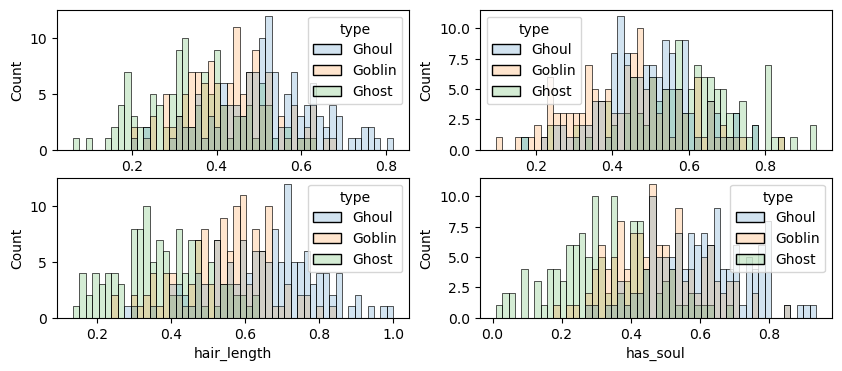

In [14]:
fig, ax = plt.subplots(2,2, figsize=(10,4))
ax=ax.flatten()
columns = ['bone_length', 'rotting_flesh', 'hair_length', 'has_soul']
bins = 50
for i, col in enumerate(columns):
    sns.histplot(data=train, x=col, hue='type', bins=bins, ax=ax[i], alpha=0.2)

In [16]:
pd.crosstab(train['type'], train['color']).style.background_gradient(axis=0)

color,black,blood,blue,clear,green,white
type,,,,,,
Ghost,14,6,6,32,15,44
Ghoul,14,4,6,42,13,50
Goblin,13,2,7,46,14,43


In [29]:
train.describe()

,id,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,443.676550,0.434160,0.506848,0.529114,0.471392
std,263.222489,0.132833,0.146358,0.169902,0.176129
min,0.000000,0.061032,0.095687,0.134600,0.009402
25%,205.500000,0.340006,0.414812,0.407428,0.348002
50%,458.000000,0.434891,0.501552,0.538642,0.466372
75%,678.500000,0.517223,0.603977,0.647244,0.600610
max,897.000000,0.817001,0.932466,1.000000,0.935721


type             1.000000
hair_length      0.397011
has_soul         0.353404
bone_length      0.241092
clear            0.081449
blue             0.008940
color            0.007793
black           -0.020063
green           -0.020080
white           -0.027354
blood           -0.080367
rotting_flesh   -0.416404
Name: type, dtype: float64


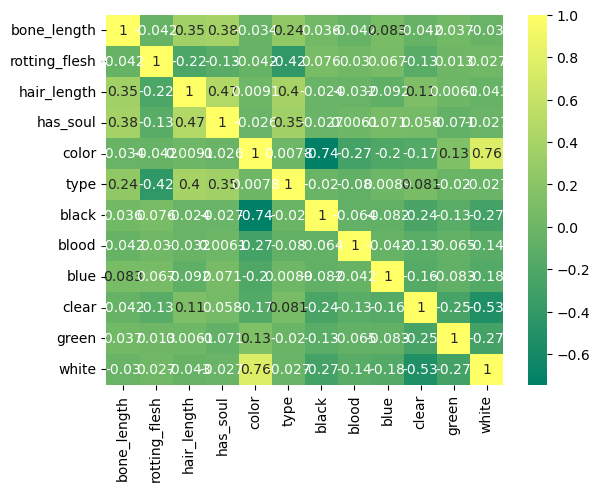

In [24]:
train_check = train.iloc[:,1:].copy()
train_check['type'].replace(['Ghost','Ghoul','Goblin'],[1,2,3], inplace=True)
train_check = pd.concat([train_check, pd.get_dummies(train_check['color'])], axis=1)
train_check['color'].replace(['black','blood','blue','clear','green','white'],[1,2,3,4,5,6], inplace=True)
corr_matrix = train_check.corr()
print(corr_matrix['type'].sort_values(ascending=False))
sns.heatmap(corr_matrix, cmap='summer', cbar=True, annot=True)
plt.show()

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())])

In [28]:
from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(train.iloc[:,1:-2])
cat_attribs = ['color']

full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        ('cat', OneHotEncoder(), cat_attribs)])

train_pre = full_pipeline.fit_transform(train.iloc[:,1:-1])
train_y = train['type'].copy()

In [44]:
from sklearn.linear_model import SGDClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_validate
scoring = 'accuracy'
cv = 5
scores = {}

In [45]:
# find best parameters for RandomForest
from sklearn.model_selection import GridSearchCV
param_grid = [{'max_features': [10,20,30,40,50,80],
               'n_estimators': [2,10,30,50]}]
forest_reg = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=cv,
                           scoring=scoring, return_train_score=True)
grid_search.fit(train_pre, train_y)
rf_mxf = grid_search.best_params_['max_features']
rf_n = grid_search.best_params_['n_estimators']
print(rf_mxf, rf_n) # 10,2

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_distribs = {'max_features': randint(low=2, high=30),
                  'n_estimators': randint(low=1, high=60)}
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=cv, scoring=scoring, random_state=42)
rnd_search.fit(train_pre, train_y)
rd_rf_mxf = rnd_search.best_params_['max_features']
rd_rf_n = rnd_search.best_params_['n_estimators']
print(rd_rf_mxf, rd_rf_n) # 8,52

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
100 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\Playdata\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Playdata\anaconda3\li

10 2
8 52


C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\Playdata\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Playdata\anaconda3\lib\s

In [60]:
# find best parameters for SVM
param_grid = [{'C': [0.001, 0.1, 1, 10, 100], 
               'gamma': [0.05, 0.1, 0.5, 1]}]
p_svm_reg = SVC(kernel='rbf')
grid_search = GridSearchCV(p_svm_reg, param_grid, cv=cv,
                           scoring=scoring, return_train_score=True)
grid_search.fit(train_pre, train_y)
svm_gamma = grid_search.best_params_['gamma']
svm_c = grid_search.best_params_['C']
print(svm_c, svm_gamma)

0.1 0.05


In [61]:
# SGDClassifier 
sgd_clf = SGDClassifier(random_state=42)
scores['sgd_clf'] = cross_validate(sgd_clf, train_pre, train_y, cv=cv, scoring=scoring)

# RandomForestClassifier
rdf_clf = RandomForestClassifier(max_features=rf_mxf, n_estimators=rf_n, random_state=42)
scores['rdf_clf'] = cross_validate(rdf_clf, train_pre, train_y, cv=cv, scoring=scoring)
                                 
rnd_rdf_clf = RandomForestClassifier(max_features=rd_rf_mxf, n_estimators=rd_rf_n, random_state=42)
scores['rnd_rdf_clf'] = cross_validate(rnd_rdf_clf, train_pre, train_y, cv=cv, scoring=scoring)                                 

# SVC
rbf_svm_clf = SVC(kernel='rbf', C=svm_c, gamma=svm_gamma, random_state=42)
scores['rbf_svm_clf'] = cross_validate(rbf_svm_clf, train_pre, train_y, cv=cv, scoring=scoring)

p_svm_clf = SVC(kernel='poly', degree=3, coef0=1, C=5, random_state=42)
scores['p_svm_clf'] = cross_validate(p_svm_clf, train_pre, train_y, cv=cv, scoring=scoring)

# LinearSVC
lsvm_clf = LinearSVC(random_state=42)
scores['lsvm_clf'] = cross_validate(lsvm_clf, train_pre, train_y, cv=cv, scoring=scoring)

# LogisticRegression # multi_class='multinomial'
logist_clf = LogisticRegression(multi_class='multinomial', random_state=42)
scores['logist_clf'] = cross_validate(logist_clf, train_pre, train_y, cv=cv, scoring=scoring)

# DecisionTreeClassifier
detree_clf = DecisionTreeClassifier(random_state=42)
scores['detree_clf'] = cross_validate(detree_clf, train_pre, train_y, cv=cv, scoring=scoring)

# KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=13)
scores['knn_clf'] = cross_validate(knn_clf, train_pre, train_y, cv=cv, scoring=scoring)

# GaussianNB
gNB_clf = GaussianNB()
scores['gNB_clf'] = cross_validate(gNB_clf, train_pre, train_y, cv=cv, scoring=scoring)

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

In [69]:
print(' '*8, '<accuracy>')
good_accuracy = 0.1; best_model = 'best_model'
for k,v in scores.items():
    print('- {0:<14}/'.format(k), end=' ')
    print('평균:', round(np.mean(v['test_score']),3))
    if good_accuracy<=np.mean(v['test_score']):
        good_accuracy = np.mean(v['test_score'])
        best_model = k
print('-'*30,'\nbest_model:', best_model)

         <accuracy>
- sgd_clf       / 평균: 0.639
- rdf_clf       / 평균: 0.633
- rnd_rdf_clf   / 평균: 0.69
- svm_clf       / 평균: 0.728
- lsvm_clf      / 평균: 0.725
- logist_clf    / 평균: 0.701
- detree_clf    / 평균: 0.609
- knn_clf       / 평균: 0.687
- gNB_clf       / 평균: 0.639
- rbf_svm_clf   / 평균: 0.752
- p_svm_clf     / 평균: 0.669
------------------------------ 
best_model: rbf_svm_clf


In [64]:
# eval(best_model).fit(train_pre, train_y)
# test_pre = full_pipeline.transform(test.iloc[:,1:])
# pred = eval(best_model).predict(test_pre)
# submission['type'] = pred
# ver = '1'
# submission.to_csv('./output/submission_ghosts_{}.csv'.format(ver), index=False)

ver 1. SVC(kernel='rbf', C=0.1, gamma=0.05, random_state=42) -> 0.729